<a href="https://colab.research.google.com/github/Axle-Bucamp/StockPricePrediction/blob/main/Stock_Market_V3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning Prediction about Stock Price using convolution
This is a standard Deep simple neural network using convolution to predict any stock price based on temporal data, analysis and some date knowledge.

Parametter part based on a lineare regression work from ""

In [94]:
%%capture
import sys 
import pandas as pd 
import numpy as np
# parrameters
import warnings
warnings.filterwarnings('ignore')
# Choose your ticker
tickerSymbol = ["BTC-CAD","ETH-CAD","BTC-USD","XAD5.MI","GOOG","^DJI","BTC","^CMC200","TSLA","AAPL","FB2A.BE","NG=F",
                "EURCAD=X","EURCHF=X","EURCNY=X","BNB-EUR","USDT-EUR","ALALO.PA","ALSPW.PA","ALNEV.PA","ALJXR.PA","ALPHA.PA",
                "ETH-USD","ATOM-USD","ADA-USD","^GDAXI",
                "ADA-EUR","ADA-CAD","SOL-CAD","^HSI","GBPUSD=X","SHIB-USD","MSFT","GIB",
                "SOL-EUR","ETH-EUR","BTC-EUR","ALC","DOGE-EUR","^GSPC","^FCHI","ALGO-USD"]

"""
,"BTC-CAD","ETH-CAD","BTC-USD","CAD=X","CADEUR=X","CADUSD=X","XAD5.MI","GOOG","ARGX","^DJI",
                "DOGE-USD","BTC","^CMC200","TSLA","AAPL","FB2A.BE","NG=F",
                "EURCAD=X","EURCHF=X","EURCNY=X","BNB-EUR","USDT-EUR","ALALO.PA","ALSPW.PA","ALNEV.PA","ALJXR.PA","ALPHA.PA",
                "ETH-USD","ATOM-USD","ADA-USD","^GDAXI",
                "ADA-EUR","ADA-CAD","SOL-CAD","^HSI","GBPUSD=X","SHIB-USD","MSFT","GIB",
                "SOL-EUR","ETH-EUR","BTC-EUR","ALC","DOGE-EUR","^GSPC","^FCHI","ALGO-USD"]
"""   

# Choose date range - format should be 'YYYY-MM-DD' 
startDate = '2017-01-01' # as strings
endDate = '2021-12-03' # as strings

# Define key model parameters
# Set days out to predict 
shifts = [7]

# Set a training percentage
train_pct = .99

# Plotting dimensions
w = 16 # width
h = 4 # height 

Some stock you may use to train (the more data the better)

All the depencies part ▶

In [95]:
%%capture
# Check if local computer has the library yfinance. If not, install. Then Import it.
!python -m pip install yfinance # Check if the machine has yfinance, if not, download yfinance
import yfinance as yf # Import library to access Yahoo finance stock data
# Add financial information and indicators 
!python -m pip install ta # Download ta
from ta import add_all_ta_features # Library that does financial technical analysis 
# Install fastai to use the date function
!python -m pip install fastai # Download fastai 
import fastai.tabular # Library that does date factors
!python -m pip install plotly # Download plotly 
import plotly.graph_objs as go  # Import the graph ojbects 

# Import sklearn modules that will help with modeling building
!python -m pip install sklearn # Download sklearn 
from sklearn.metrics import mean_squared_error # Install error metrics 
from sklearn.preprocessing import StandardScaler # to scale for ann
# Go through each shift....
import pickle
from joblib import dump, load
from google.colab import files

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

## Downloading the data from internet
using Yahoo API because it s free, we can get many data about the any stock we want so let s get at it.

In [96]:
# Create ticker yfinance object
data = []
i = 0
for t in tickerSymbol:
  print('-----------------------  iteration :' + str(i) + " symbol : " + t)
  tickerData = yf.Ticker(t)
  # Create historic data dataframe and fetch the data for the dates given. 
  df = tickerData.history(start = startDate, end = endDate)

  # to date format so we can get some juicy details
  date_change = '%Y-%m-%d'
  df['Date'] = df.index
  df['Date'] = pd.to_datetime(df['Date'], format = date_change)
  Dates = df['Date']

  # add financial details
  df = add_all_ta_features(df, "Open", "High", "Low", "Close", "Volume", fillna=True)

  # Define the date parts 
  fastai.tabular.add_datepart(df,'Date', drop = 'True')
  # Ensure the correct format
  df['Date'] = pd.to_datetime(df.index.values, format = date_change)
  # Add the date parts
  fastai.tabular.add_cyclic_datepart(df, 'Date', drop = 'True')

  data.append(df)
  i +=1

# Print statement showing the download is done

# Show what the first 5 rows of the data frame
# Note the dataframe has:
#   - Date (YYY-MM-DD) as an index
#   - Open (price the stock started as)
#   - High (highest price stock reached that day)
#   - Low (lowest price stock reached that day)
#   - Close (price the stock ended the day as)
#   - Volume (how many shares were traded that day)
#   - Dividends (any earnings shared to shareholders)
#   - Stock Splits (any stock price changes)
# Create ticker yfinance object

print('-----------------------')
print('Done!')
data[0].head()

-----------------------  iteration :0 symbol : BTC-CAD
-----------------------  iteration :1 symbol : ETH-CAD
-----------------------  iteration :2 symbol : BTC-USD
-----------------------  iteration :3 symbol : XAD5.MI
-----------------------  iteration :4 symbol : GOOG
-----------------------  iteration :5 symbol : ^DJI
-----------------------  iteration :6 symbol : BTC
-----------------------  iteration :7 symbol : ^CMC200
-----------------------  iteration :8 symbol : TSLA
-----------------------  iteration :9 symbol : AAPL
-----------------------  iteration :10 symbol : FB2A.BE
-----------------------  iteration :11 symbol : NG=F
-----------------------  iteration :12 symbol : EURCAD=X
-----------------------  iteration :13 symbol : EURCHF=X
-----------------------  iteration :14 symbol : EURCNY=X
-----------------------  iteration :15 symbol : BNB-EUR
-----------------------  iteration :16 symbol : USDT-EUR
-----------------------  iteration :17 symbol : ALALO.PA
----------------

,Open,High,Low,Close,Volume,Dividends,Stock Splits,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,...,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_kama,others_dr,others_dlr,others_cr,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,weekday_cos,weekday_sin,day_month_cos,day_month_sin,month_year_cos,month_year_sin,day_year_cos,day_year_sin
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-11,8393.059570,8715.841797,7867.571777,8062.072754,6224697351,0,0,-3.370159e+09,6224697351,-0.541417,0.000000e+00,0.000000,0.000000,-3.893218e+09,8215.162109,50.000000,1000.000000,8062.072754,8062.072754,8062.072754,0.000000,0.000000,0.0,0.0,8215.162109,9063.432129,7366.892090,20.651328,0.409764,0.0,0.0,7867.571777,8715.841797,8291.706787,10.521736,0.229291,0.0,0.0,0.000000,0.000000,...,0.0,100.000000,0.0,0.0,0.0,0.000000,0.000000,22.929135,22.929135,-77.070865,0.0,0.0,0.000000,0.000000,0.000000,8062.072754,-64.109388,0.000000,0.000000,2017,11,45,11,5,315,False,False,False,False,False,False,1510358400,-0.222521,-0.974928,-0.500000,0.866025,0.5,-0.866025,0.638749,-0.769415
2017-11-12,7983.260254,8401.225586,6998.656250,7551.233398,11367772743,0,0,-5.780697e+09,-5143075392,-0.328589,-5.807106e+12,-7301.277751,-7301.277751,-4.710915e+09,7850.210032,0.000000,1000.000000,7806.653076,8317.492432,7295.813721,13.087282,0.250000,0.0,0.0,7932.766927,9058.186605,6807.347249,28.373950,0.330493,0.0,0.0,6998.656250,8715.841797,7857.249023,21.996437,0.321792,0.0,0.0,-40.750718,-8.150144,...,0.0,0.000000,0.0,0.0,0.0,-100.000000,24.549826,32.179234,27.554184,-67.820766,0.0,0.0,6.210938,1.242188,4.968750,7809.834426,-6.336328,-6.545978,-6.336328,2017,11,45,12,6,316,False,False,False,False,False,False,1510444800,0.623490,-0.781831,-0.669131,0.743145,0.5,-0.866025,0.651899,-0.758306
2017-11-13,7536.232910,8651.573242,7416.404297,8354.822266,7977501423,0,0,-1.636406e+09,2834426031,-0.063997,-4.061715e+12,5172.114809,-1064.581471,1.286522e+08,7940.911933,42.751270,1106.418227,7989.376139,8653.509389,7325.242889,16.625410,0.775130,0.0,0.0,8002.155707,9164.158474,6840.152941,29.042243,0.651749,0.0,0.0,6998.656250,8715.841797,7857.249023,21.493362,0.789761,0.0,0.0,-8.109568,-8.142028,...,1.0,62.881595,0.0,0.0,0.0,-96.564328,42.770842,78.976091,44.694820,-21.023909,0.0,0.0,6.807360,2.355222,4.452138,8038.428549,10.641823,10.112798,3.631194,2017,11,46,13,0,317,False,False,False,False,False,False,1510531200,1.000000,0.000000,-0.809017,0.587785,0.5,-0.866025,0.664855,-0.746972
2017-11-14,8357.357422,8617.231445,8208.361328,8449.300781,4070880183,0,0,-9.095002e+08,6905306214,-0.030684,-3.426525e+12,3804.659137,558.498732,8.949861e+08,8007.391807,53.295662,1118.929893,8104.357300,8803.966289,7404.748311,17.265009,0.746526,0.0,0.0,8107.857910,9081.577515,7134.138306,24.019158,0.675329,0.0,0.0,6998.656250,8715.841797,7857.249023,21.188424,0.844780,0.0,0.0,25.093148,-1.494993,...,0.0,65.618923,0.0,0.0,0.0,-93.453511,44.466974,84.478031,65.211118,-15.521969,0.0,0.0,2.703214,2.424820,0.278393,8218.142150,1.130826,1.124480,4.803083,2017,11,46,14,1,318,False,False,False,False,False,False,1510617600,0.623490,0.781831,-0.913545,0.406737,0.5,-0.866025,0.677615,-0.735417
2017-11-15,8448.040039,9369.445312,8448.040039,9339.750000,5363263659,0,0,4

In [97]:
for i in range(len(data)):
  data[i] = data[i].fillna(0)

In [98]:
data[0].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,...,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_kama,others_dr,others_dlr,others_cr,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,weekday_cos,weekday_sin,day_month_cos,day_month_sin,month_year_cos,month_year_sin,day_year_cos,day_year_sin
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-11,8393.059570,8715.841797,7867.571777,8062.072754,6224697351,0,0,-3.370159e+09,6224697351,-0.541417,0.000000e+00,0.000000,0.000000,-3.893218e+09,8215.162109,50.000000,1000.000000,8062.072754,8062.072754,8062.072754,0.000000,0.000000,0.0,0.0,8215.162109,9063.432129,7366.892090,20.651328,0.409764,0.0,0.0,7867.571777,8715.841797,8291.706787,10.521736,0.229291,0.0,0.0,0.000000,0.000000,...,0.0,100.000000,0.0,0.0,0.0,0.000000,0.000000,22.929135,22.929135,-77.070865,0.0,0.0,0.000000,0.000000,0.000000,8062.072754,-64.109388,0.000000,0.000000,2017,11,45,11,5,315,False,False,False,False,False,False,1510358400,-0.222521,-0.974928,-0.500000,0.866025,0.5,-0.866025,0.638749,-0.769415
2017-11-12,7983.260254,8401.225586,6998.656250,7551.233398,11367772743,0,0,-5.780697e+09,-5143075392,-0.328589,-5.807106e+12,-7301.277751,-7301.277751,-4.710915e+09,7850.210032,0.000000,1000.000000,7806.653076,8317.492432,7295.813721,13.087282,0.250000,0.0,0.0,7932.766927,9058.186605,6807.347249,28.373950,0.330493,0.0,0.0,6998.656250,8715.841797,7857.249023,21.996437,0.321792,0.0,0.0,-40.750718,-8.150144,...,0.0,0.000000,0.0,0.0,0.0,-100.000000,24.549826,32.179234,27.554184,-67.820766,0.0,0.0,6.210938,1.242188,4.968750,7809.834426,-6.336328,-6.545978,-6.336328,2017,11,45,12,6,316,False,False,False,False,False,False,1510444800,0.623490,-0.781831,-0.669131,0.743145,0.5,-0.866025,0.651899,-0.758306
2017-11-13,7536.232910,8651.573242,7416.404297,8354.822266,7977501423,0,0,-1.636406e+09,2834426031,-0.063997,-4.061715e+12,5172.114809,-1064.581471,1.286522e+08,7940.911933,42.751270,1106.418227,7989.376139,8653.509389,7325.242889,16.625410,0.775130,0.0,0.0,8002.155707,9164.158474,6840.152941,29.042243,0.651749,0.0,0.0,6998.656250,8715.841797,7857.249023,21.493362,0.789761,0.0,0.0,-8.109568,-8.142028,...,1.0,62.881595,0.0,0.0,0.0,-96.564328,42.770842,78.976091,44.694820,-21.023909,0.0,0.0,6.807360,2.355222,4.452138,8038.428549,10.641823,10.112798,3.631194,2017,11,46,13,0,317,False,False,False,False,False,False,1510531200,1.000000,0.000000,-0.809017,0.587785,0.5,-0.866025,0.664855,-0.746972
2017-11-14,8357.357422,8617.231445,8208.361328,8449.300781,4070880183,0,0,-9.095002e+08,6905306214,-0.030684,-3.426525e+12,3804.659137,558.498732,8.949861e+08,8007.391807,53.295662,1118.929893,8104.357300,8803.966289,7404.748311,17.265009,0.746526,0.0,0.0,8107.857910,9081.577515,7134.138306,24.019158,0.675329,0.0,0.0,6998.656250,8715.841797,7857.249023,21.188424,0.844780,0.0,0.0,25.093148,-1.494993,...,0.0,65.618923,0.0,0.0,0.0,-93.453511,44.466974,84.478031,65.211118,-15.521969,0.0,0.0,2.703214,2.424820,0.278393,8218.142150,1.130826,1.124480,4.803083,2017,11,46,14,1,318,False,False,False,False,False,False,1510617600,0.623490,0.781831,-0.913545,0.406737,0.5,-0.866025,0.677615,-0.735417
2017-11-15,8448.040039,9369.445312,8448.040039,9339.750000,5363263659,0,0,4

## Some usefull function

In [99]:
# Ensure column types are correct

def CorrectColumnTypes(df):
  # Input: dataframe 
  # ouptut: dataframe (with column types changed)

  # Numbers
  for col in df.columns[1:]:
      df[col] = df[col].astype('float')

  #for col in df.columns[-25:]:
  #    df[col] = df[col].astype('float')

  # Categories 
  #for col in df.columns[80:-25]:
  #    df[col] = df[col].astype('category').cat.codes
      # Corriger le type, 
      # Soit transformer les cat en one hot soit 
      # Soit cat code sur tout le dataset 

  return df 

In [100]:
# Create the lags 
def CreateLags(df,lag_size):
  # inputs: dataframe , size of the lag (int)
  # ouptut: dataframe ( with extra lag column), shift size (int)

  # add lag
  shiftdays = lag_size
  shift = -shiftdays
  df['Close_lag'] = df['Close'].shift(shift)
  return df, shift


In [101]:
# Split the testing and training data 
def SplitData(df, train_pct, shift):
  # inputs: dataframe , training_pct (float between 0 and 1), size of the lag (int)
  # ouptut: x train dataframe, y train data frame, x test dataframe, y test dataframe, train data frame, test dataframe

  train_pt = int(len(df)*train_pct)
  
  train = df.iloc[:train_pt,:]
  test = df.iloc[train_pt:,:]
  
  x_train = train.iloc[:shift,1:-1]
  y_train = train['Close_lag'][:shift] 
  x_test = test.iloc[:shift,1:-1]
  y_test = test['Close'][:shift] 

  return x_train, y_train, x_test, y_test, train, test

# Defining the model : Convlutinal and linear type
You may change some part of it, if you got more data maybe a bigger model will improve the prediction, if not maybe a smaller. The basic idea here is that the convolution learn to link the different variation style of the stock price during 20 day then it allow the linear part to learn from the past variation to improve it s computation, this allow us to be more consistant on mid term prediction.

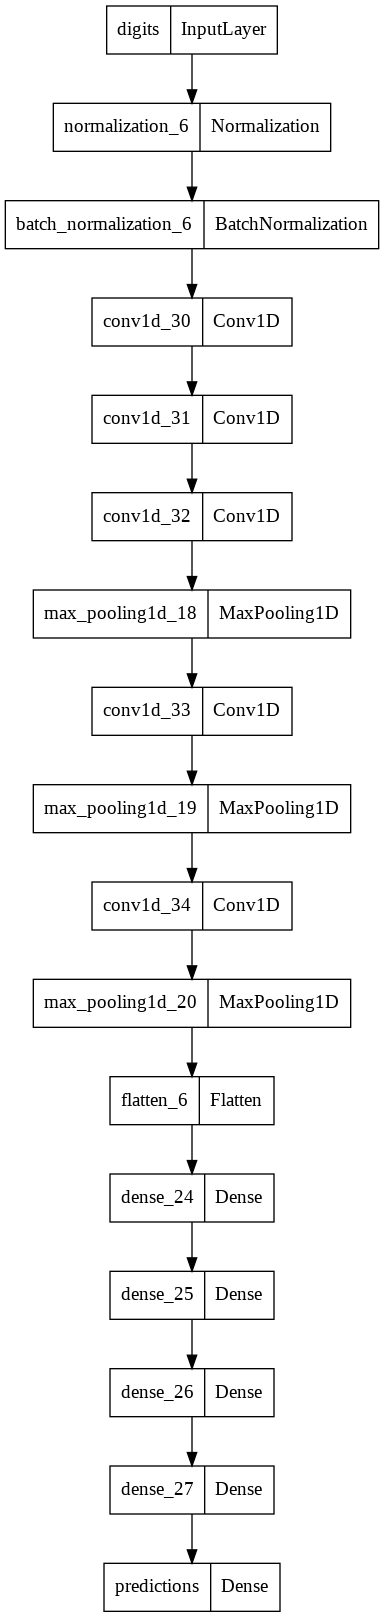

In [124]:

#################################################################
inputs = keras.Input(shape=(40,110), name="digits")
norm = keras.layers.Normalization(mean=None, variance=None)(inputs)
norm = layers.BatchNormalization()(norm)
Conv1 = layers.Conv1D(filters=128, kernel_size=10,padding="causal", activation='relu')(norm)
Conv1 = layers.Conv1D(filters=128, kernel_size=10,padding="causal", activation='relu')(Conv1)
Conv1 = layers.Conv1D(filters=128, kernel_size=10,padding="causal", activation='relu')(Conv1)
Max1 = layers.MaxPooling1D(5)(Conv1)
Conv2 = layers.Conv1D(filters=64, kernel_size=5,padding="causal", activation='relu')(Max1)
Max1 = layers.MaxPooling1D(3)(Conv2)
Conv3 = layers.Conv1D(filters=64, kernel_size=2,padding="causal", activation='relu')(Max1)
Max1 = layers.MaxPooling1D(2)(Conv3)
Flaterning = layers.Flatten()(Max1)

Dense1 = layers.Dense(128, activation="relu")(Flaterning)
Dense1 = layers.Dense(128, activation="relu")(Dense1)
Dense1 = layers.Dense(128, activation="relu")(Dense1)
Dense1 = layers.Dense(128, activation="relu")(Dense1)
outputs = layers.Dense(4, activation="softmax", name="predictions")(Dense1)
#################################################################
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
      optimizer=keras.optimizers.Adam(
        learning_rate=0.01),  # Optimizer
      # Loss function to minimize
      loss=keras.losses.CategoricalCrossentropy(),
      metrics=[keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)])

earlyStopping = EarlyStopping(monitor='val_loss', patience=8, verbose=0, mode='min')
checkpointer=ModelCheckpoint("weight", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq=1),
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-5, mode='min')

# graph
plot_model(model, to_file='Terminatotor_graph.png')

# Trainning the model

In [103]:
for j in shifts: 
  print('#####################################################################')
  print(' days out: ' + str(j))
  print()
  
  print("preprocessing and splitting : ")
  print('---------------------------------')
  df = pd.concat(data)
  
  df_lag, shift = CreateLags(df,j)
  df_lag = CorrectColumnTypes(df_lag)
  x_train, y_train, x_test, y_test, train, test = SplitData(df, train_pct, shift)
  
  trainning_arrayY = []
  trainning_arrayX = []
  check = []
  for i in range(x_train.shape[0] - 40):
    y = y_train[i+40] / x_train["Close"][i+40]
    trainning_arrayX.append( np.array(x_train[i:i+40]))
    check.append(y)
    if y > 1.05:
      trainning_arrayY.append( [1,0,0,0] )
    elif  y < 0.95:
      trainning_arrayY.append( [0,0,0,1] )
    elif  y < 1.0 :
      trainning_arrayY.append( [0,0,1,0] )
    else :
      trainning_arrayY.append( [0,1,0,0] )


  Ymax = np.max(np.array(trainning_arrayY)) 
  trainning_arrayX = np.nan_to_num(np.array(trainning_arrayX))

  #scaler = StandardScaler()
  #scaler.fit(np.array(trainning_arrayY).reshape(-1, 1))
  #trainning_arrayY = scaler.transform(np.array(trainning_arrayY).reshape(-1, 1)).reshape(-1)
  # Deep Learning trainning

#####################################################################
 days out: 7

preprocessing and splitting : 
---------------------------------


In [104]:
trainning_arrayY = np.array(trainning_arrayY)
sum1 = np.sum(trainning_arrayY[:,0])
sum2 = np.sum(trainning_arrayY[:,1])
sum3 = np.sum(trainning_arrayY[:,2])
sum4 = np.sum(trainning_arrayY[:,3])

min = np.min([sum1,sum2,sum3,sum4])

In [105]:
# balance sample 
import random
index=[]
for i in range(trainning_arrayY.shape[0]):
  r = random.random()
  if trainning_arrayY[i,0] == 1:
    if r > min / sum1  :
      sum1 -= 1
      index.append(i)

  if trainning_arrayY[i,1] == 1:
    if r > min/sum2  :
      sum2 -= 1
      index.append(i)

  if trainning_arrayY[i,2] == 1:
    if r > min / sum3  :
      sum3 -= 1
      index.append(i)

  if trainning_arrayY[i,2] == 1:
    if r > min / sum3 :
      sum4 -= 1
      index.append(i)

trainning_arrayY = np.delete(trainning_arrayY, index,0)
trainning_arrayX = np.delete(trainning_arrayX, index,0)
check = np.delete(check, index,0)

In [125]:
print("Deep Learning trainning")

#################################################################
# inputs: x train data, y train data, x test data, y test data (all dataframe's)
# output:   the predicted values for the test data (list)
################################################################# 

model.fit(np.array(trainning_arrayX),np.array(trainning_arrayY),batch_size=100,epochs=20, shuffle=True,validation_split=0.3, callbacks=[earlyStopping, reduce_lr_loss,checkpointer], )

print('#####################################################################')

Deep Learning trainning
Epoch 1/20
293/293 [==============================] - 108s 364ms/step - loss: 1.3797 - categorical_accuracy: 0.3055 - val_loss: 1.3413 - val_categorical_accuracy: 0.3437 - lr: 0.0100
Epoch 2/20
293/293 [==============================] - 106s 363ms/step - loss: 1.2880 - categorical_accuracy: 0.3809 - val_loss: 1.2196 - val_categorical_accuracy: 0.4129 - lr: 0.0100
Epoch 3/20
293/293 [==============================] - 107s 364ms/step - loss: 1.2055 - categorical_accuracy: 0.4119 - val_loss: 1.1577 - val_categorical_accuracy: 0.3965 - lr: 0.0100
Epoch 4/20
293/293 [==============================] - 107s 364ms/step - loss: 1.1814 - categorical_accuracy: 0.4382 - val_loss: 1.1539 - val_categorical_accuracy: 0.4608 - lr: 0.0100
Epoch 5/20
293/293 [==============================] - 106s 363ms/step - loss: 1.1565 - categorical_accuracy: 0.4633 - val_loss: 1.1301 - val_categorical_accuracy: 0.4806 - lr: 0.0100
Epoch 6/20
293/293 [==============================] - 110s 37

In [127]:
lr_pred = model.predict(np.array(trainning_arrayX)) 

prediction = []
truth = []
i = 0
groupe1t = 0
groupe2t= 0
groupe3t= 0
groupe4t= 0

groupe1f = 0
groupe2f= 0
groupe3f= 0
groupe4f= 0

for pred in lr_pred:
  groupe = tf.math.argmax(pred,-1)
  prediction.append(groupe)
  if groupe == tf.math.argmax(trainning_arrayY[i]):
    if groupe == 0:
      groupe1t +=1
    if groupe == 1:
      groupe2t +=1
    if groupe == 2:
      groupe3t +=1
    if groupe == 3:
      groupe4t +=1
  else:
    if groupe == 0:
      groupe1f +=1
    if groupe == 1:
      groupe2f +=1
    if groupe == 2:
      groupe3f +=1
    if groupe == 3:
      groupe4f +=1
  i +=1

In [128]:
print(groupe1t)
print(groupe2t)
print(groupe3t)
print(groupe4t)

8757
6812
5931
8467


In [129]:
print(groupe1f)
print(groupe2f)
print(groupe3f)
print(groupe4f)

2647
4136
3645
1423


In [130]:
print(groupe1f / groupe1t)
print(groupe2f/ groupe2t)
print(groupe3f / groupe3t)
print(groupe4f/groupe4t)

0.30227246774009364
0.6071638285378743
0.6145675265553869
0.16806424943899848


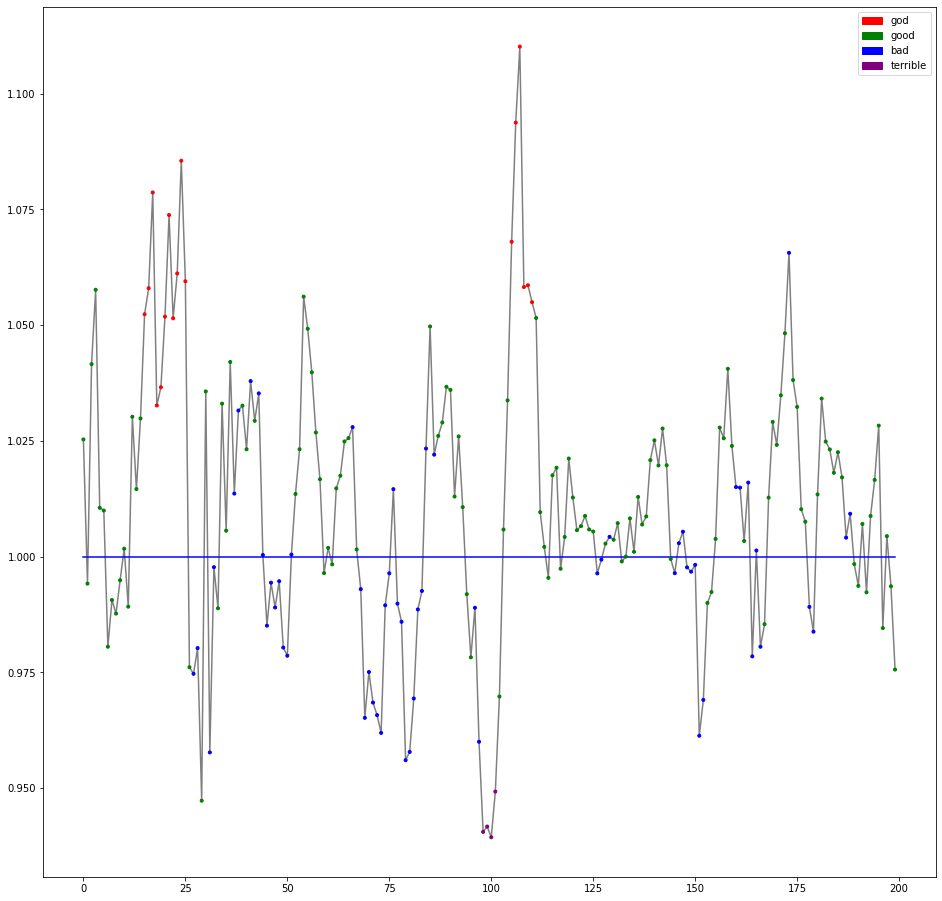

In [132]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
debut = 6000
end = 6200
x = np.array(range(len(check[debut:end]) )).astype(float)
y = check[debut:end]
label = prediction[debut:end]

colors = ['red','green','blue','purple']

fig = plt.figure(figsize=(16,16))
scatter = plt.scatter(x, y, marker='.',linewidths=1, c=label, cmap=matplotlib.colors.ListedColormap(colors),zorder=2)
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='god')
green_patch = mpatches.Patch(color='green', label='good')
blue_patch = mpatches.Patch(color='blue', label='bad')
purple_patch = mpatches.Patch(color='purple', label='terrible')
plt.legend(handles=[red_patch,green_patch,blue_patch,purple_patch])
plt.plot(x,y,color='grey',zorder=1)
plt.plot(x,np.ones(len(check[debut:end] )),color='b',zorder=1)